In [1]:
from sqlalchemy import create_engine, String, Integer, BigInteger, Column, Float, insert, select, update,delete, func
from sqlalchemy.orm import sessionmaker, declarative_base
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns 
from datetime import datetime
import kaggle 

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans

### 1. **customer segmentation** 
- **Analysis**: Use clustering techniques (e.g., K-means) to segment customers based on their purchasing behavior, age, gender, location, and frequency of purchases.
- **Objective**: Understand different customer profiles and tailor marketing strategies accordingly.


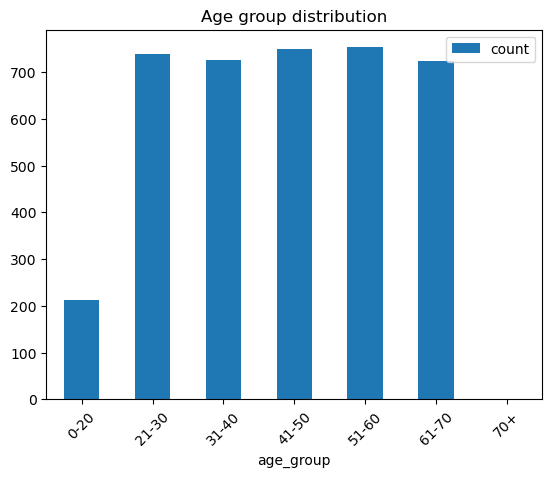

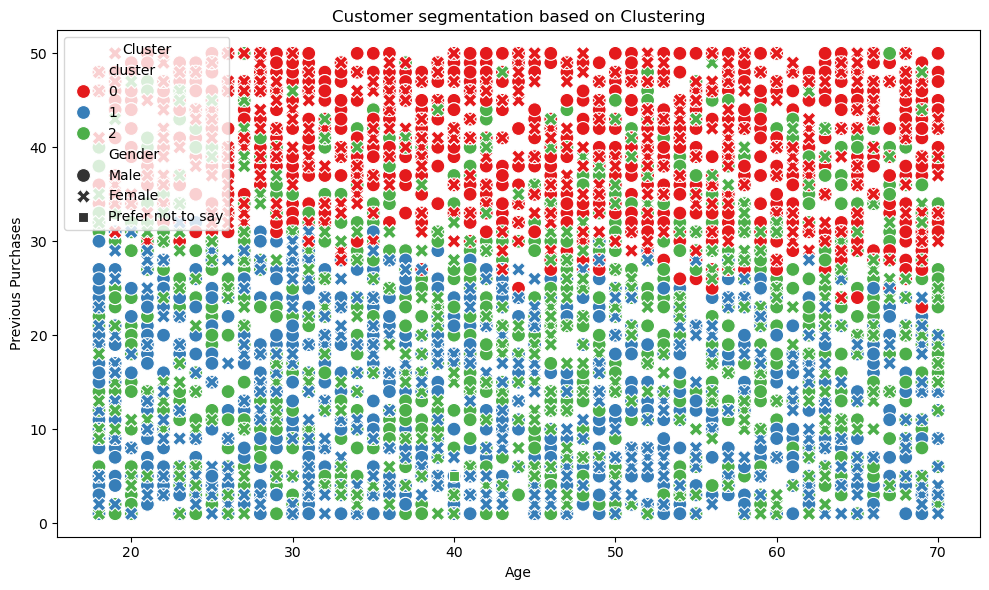

In [19]:
#age group
df['Age'].describe()

bins = [0,20,30,40,50,60,70,100]
labels = ['0-20','21-30','31-40','41-50','51-60','61-70','70+']

df['age_group'] = pd.cut(df['Age'], bins = bins, labels = labels, right= True)

df['age_group'] = pd.Categorical(df['age_group'], categories = labels, ordered = True)

age_gp_cnt = df['age_group'].value_counts().reset_index()
age_gp_cnt.columns = ['age_group','count']

age_gp_cnt = age_gp_cnt.sort_values(by = 'age_group')


age_gp_cnt.plot(kind = 'bar', x = 'age_group', y = 'count')
plt.xticks(rotation = 45)
plt.title('Age group distribution')


#Clustering: K-menas
#categorise variables
categorical_features = ['Gender','Category','Location','Size','Color','Season','Payment Method','Shipping Type','Frequency of Purchases']
df_encoded = pd.get_dummies(df[categorical_features], drop_first = True)

#scalue numerical features
scaler = StandardScaler()
numerical_features = ['Age','Review Rating','Previous Purchases','Purchase Amount (USD)'] #added purchase amount make clustering blur
df_scaled = scaler.fit_transform(df[numerical_features])

X = np.hstack((df_scaled, df_encoded.values))

#k-menas clustering 
kmenas = KMeans(n_clusters = 3, random_state = 42)
df['cluster'] = kmenas.fit_predict(X)

#print(df[['Age','Gender','Location','Frequency of Purchases','cluster','age_group']])

plt.figure(figsize = (10,6))
sns.scatterplot(data = df, x = 'Age', y = 'Previous Purchases', hue = 'cluster', palette = 'Set1', style = 'Gender', s = 100)
plt.title('Customer segmentation based on Clustering')
plt.xlabel('Age')
plt.ylabel('Previous Purchases')
plt.legend(title = 'Cluster')
plt.tight_layout()
plt.show()



### 2. **Sales Performance Analysis**
   - **Analysis**: Analyze the total sales by category, season, or location. Create visualizations to show trends over time.
   - **Tools**: Use bar charts or line graphs to present findings.
   - **Objective**: Identify which categories or locations generate the most revenue.

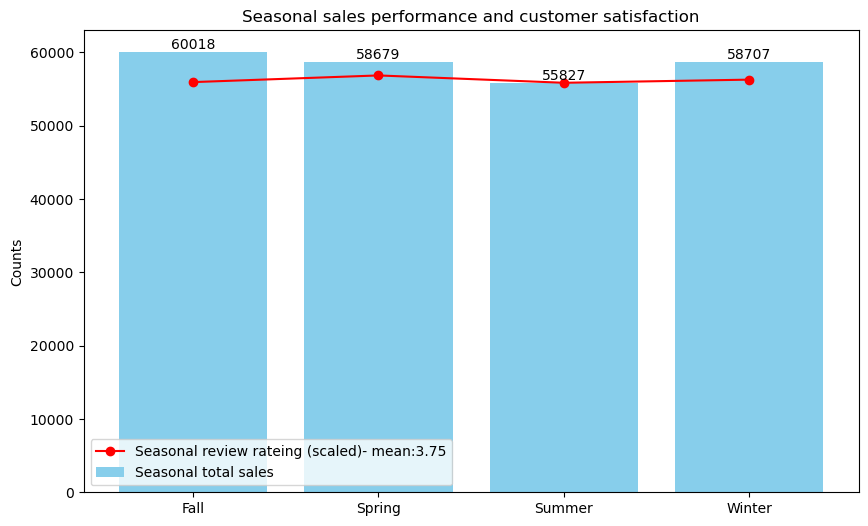

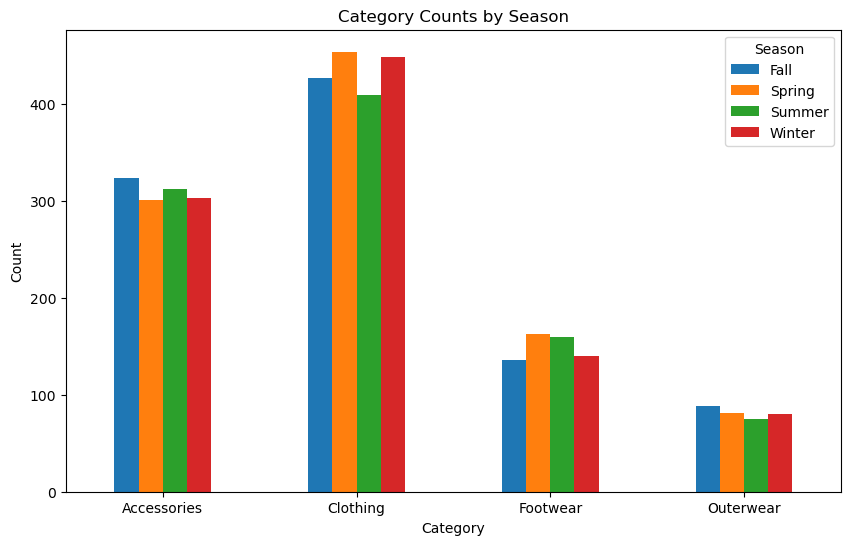

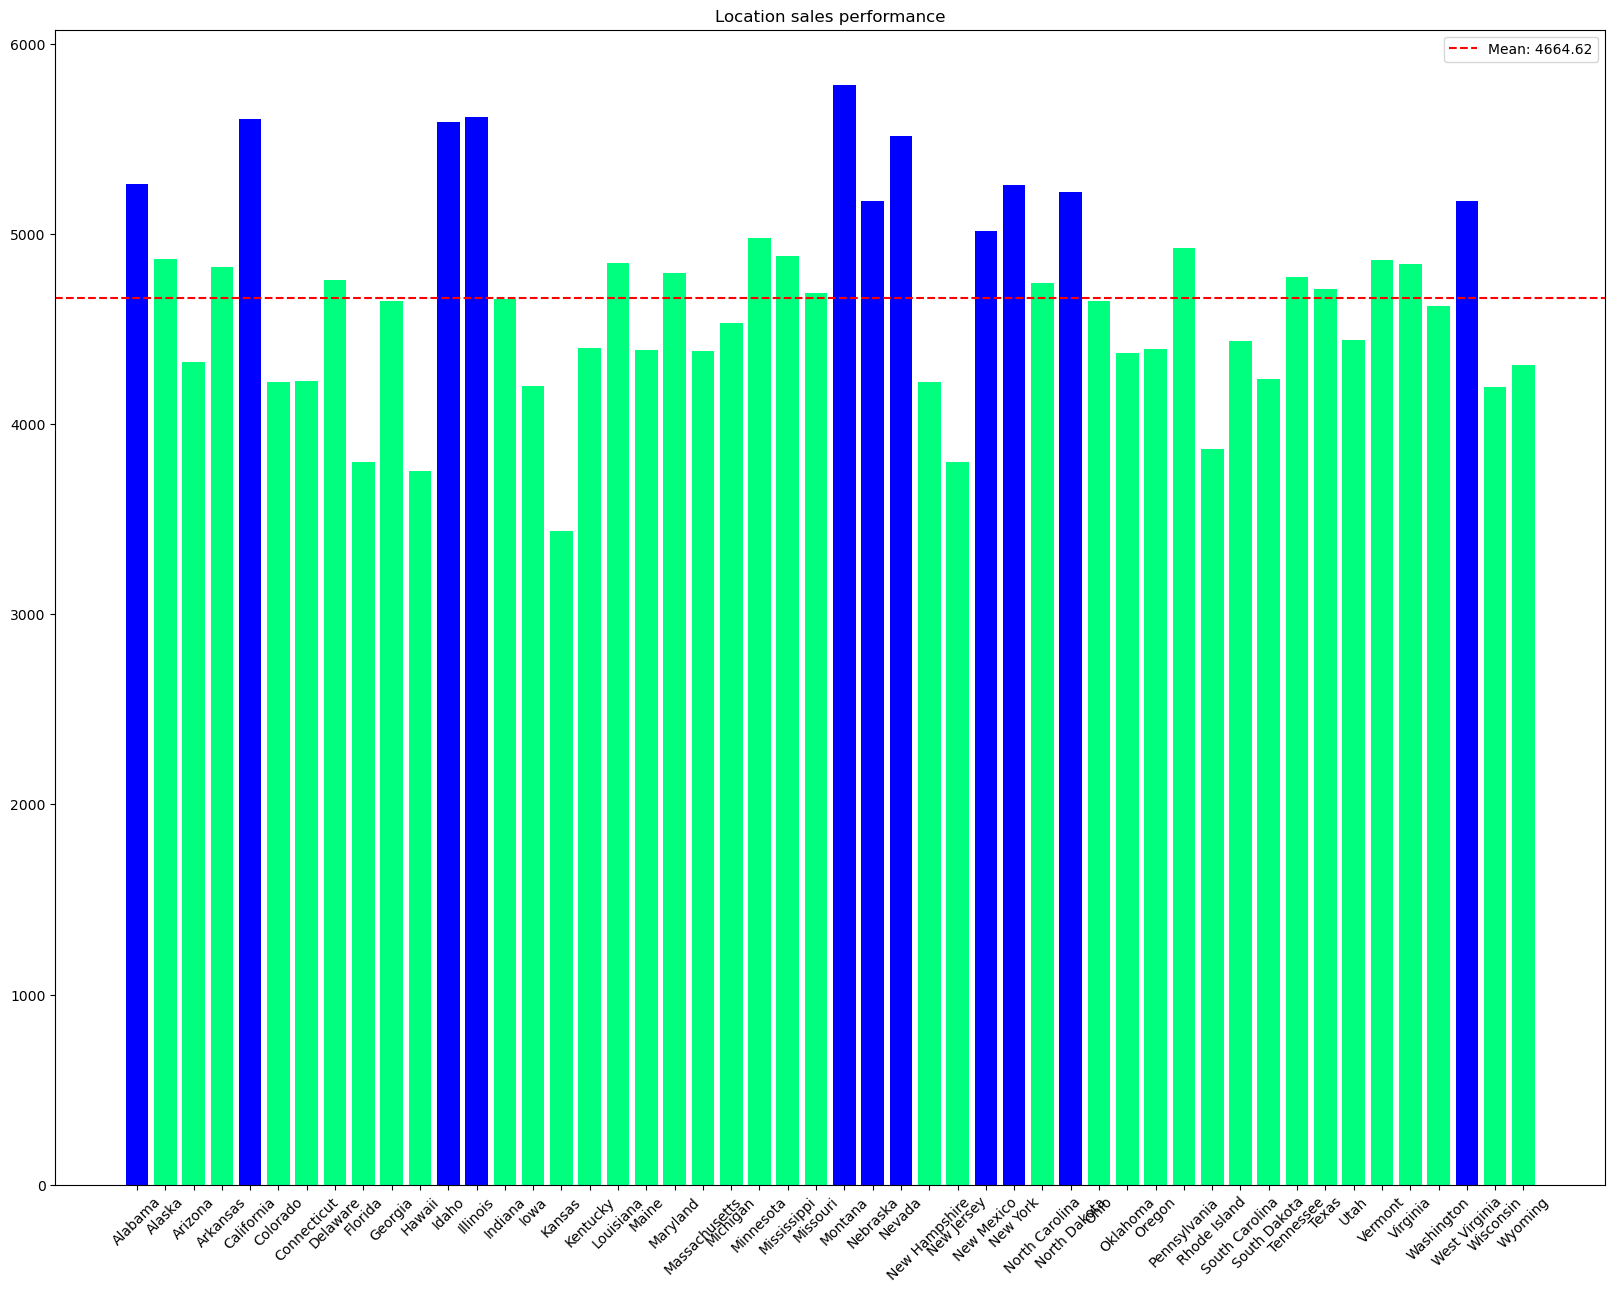

In [21]:
#category, location, season, 
# Group by 'Season' and aggregate 'Location' and 'Category' using sum
seasonal_performance = df.groupby('Season').agg({'Purchase Amount (USD)':'sum',
                                           'Review Rating':'mean'
                                          }).reset_index()
mean = seasonal_performance['Review Rating'].mean().round(2)

plt.figure(figsize = (10,6))
plt.bar(seasonal_performance['Season'], seasonal_performance['Purchase Amount (USD)'], color = 'skyblue', label = 'Seasonal total sales')
plt.plot(seasonal_performance['Season'], seasonal_performance['Review Rating']*15000, marker = 'o', color = 'r', label = f'Seasonal review rateing (scaled)- mean:{mean}')

for i, amount in enumerate(seasonal_performance['Purchase Amount (USD)']):
    plt.text(i, amount, f'{amount}', ha='center', va='bottom')

plt.ylabel('Counts')
plt.title('Seasonal sales performance and customer satisfaction')
plt.legend()
plt.show()


seasonal_category = df.groupby('Season')['Category'].value_counts().reset_index(name = 'Count')
# Create a pivot table for easier plotting
pivot_data = seasonal_category.pivot(index='Category', columns='Season', values='Count')

# Plotting
pivot_data.plot(kind='bar', figsize=(10, 6), color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])

    
plt.title('Category Counts by Season')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Season')
#plt.tight_layout()
plt.show()


#location performance 
plt.figure(figsize = (20,15))
loc_performance = df.groupby('Location')['Purchase Amount (USD)'].sum().reset_index(name = 'Amount')
mean = loc_performance['Amount'].mean().round(2)
colors = ['springgreen' if amount < 5000 else 'blue' for amount in loc_performance['Amount']]

plt.bar(loc_performance['Location'], loc_performance['Amount'], color = colors)
plt.xticks(rotation =45)
plt.axhline(mean, color = 'r', label = f'Mean: {mean}', linestyle = '--')
plt.title('Location sales performance')
plt.legend()

plt.show()

### 3. **Purchase Behavior Analysis**
   - **Analysis**: Investigate the relationship between variables such as age, gender, and purchase amount. For example, analyze if older customers spend more than younger ones.
   - **Objective**: Determine key factors that influence purchasing decisions.

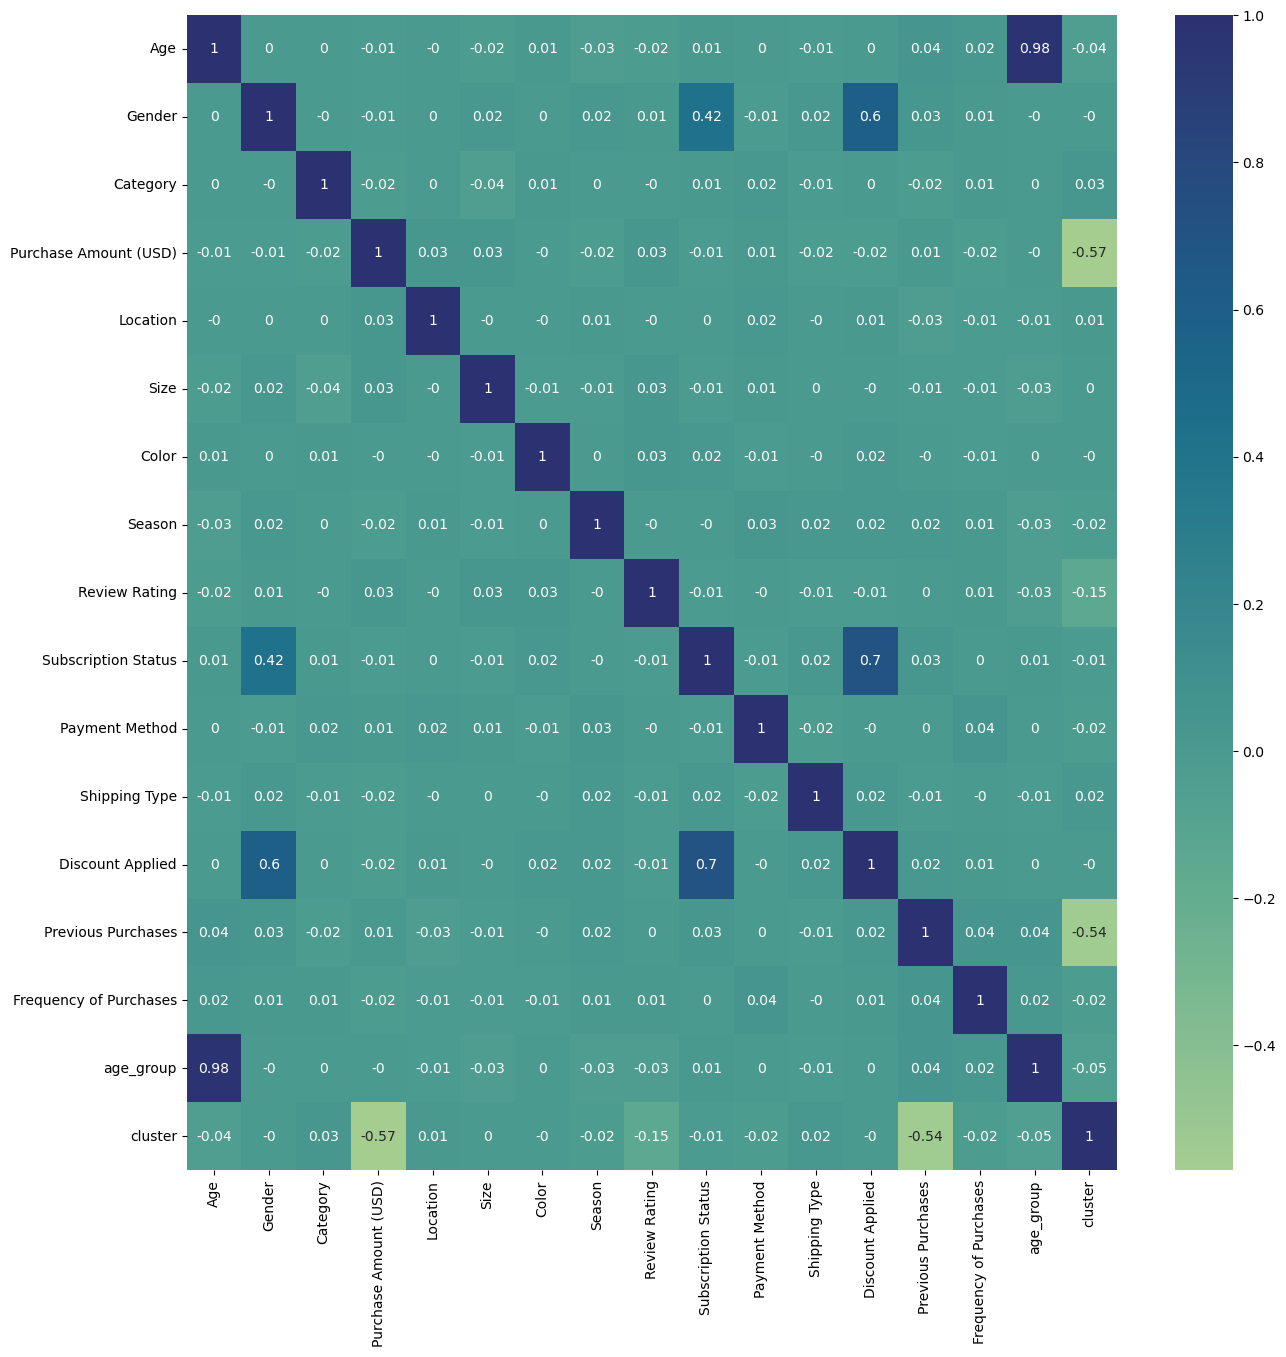

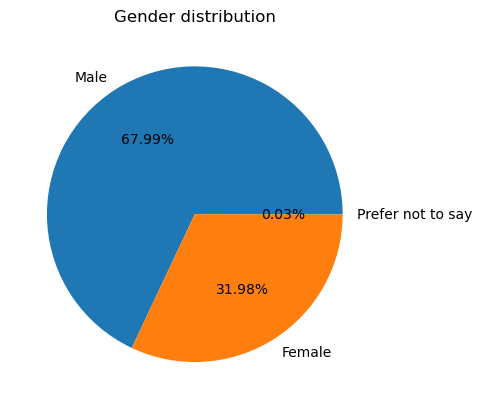

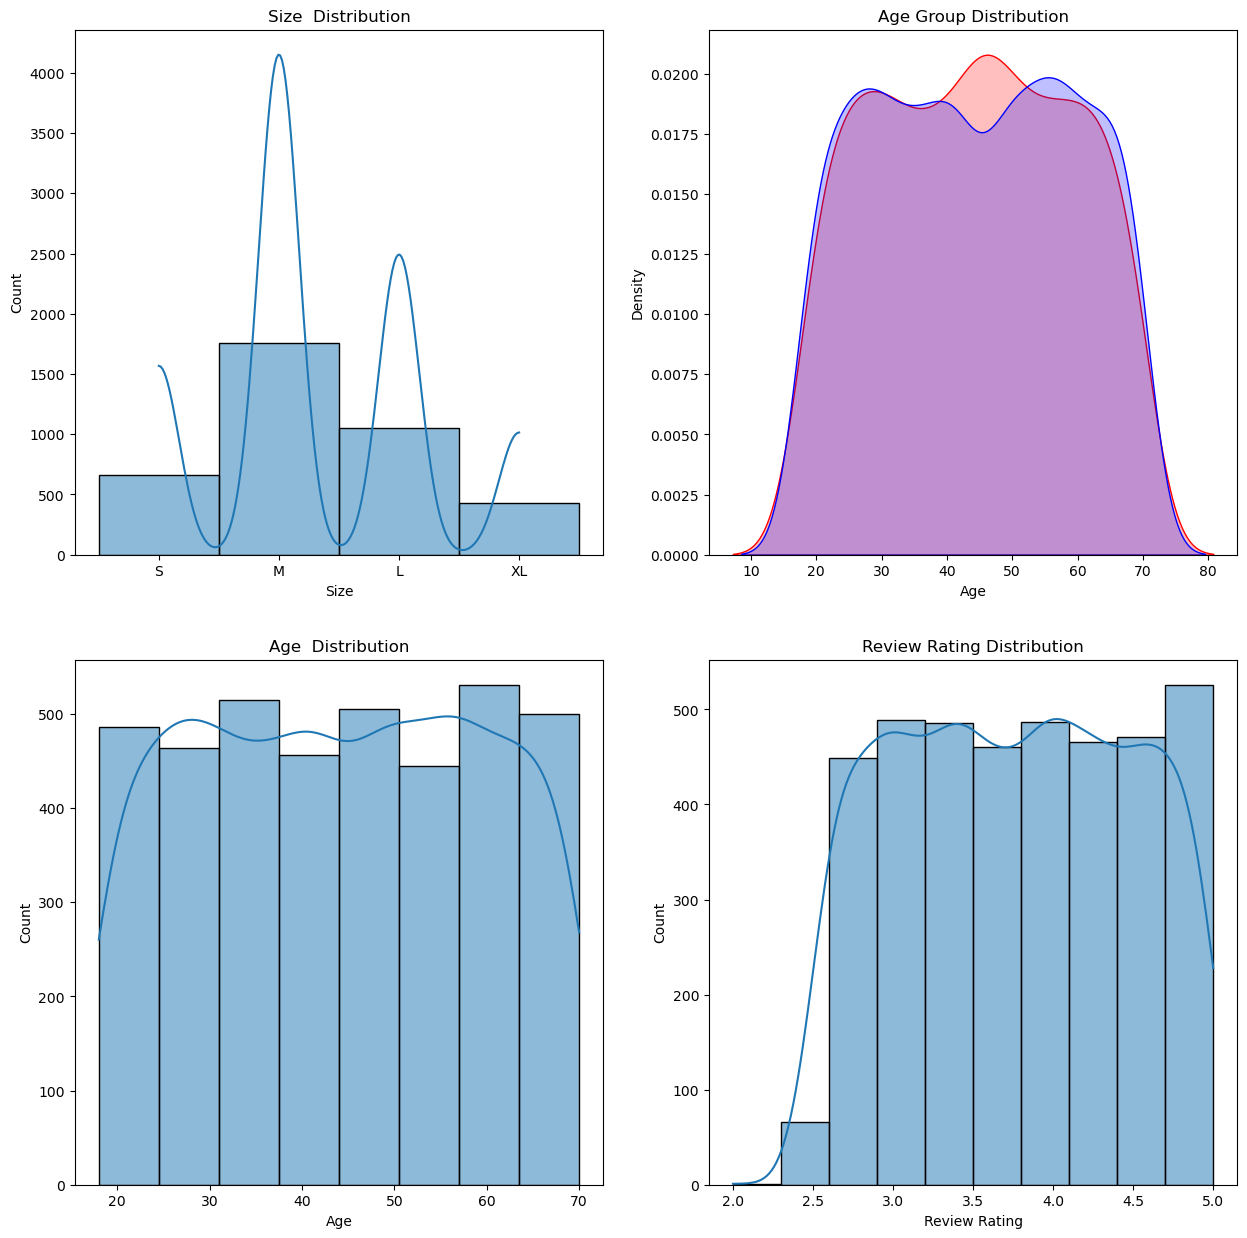

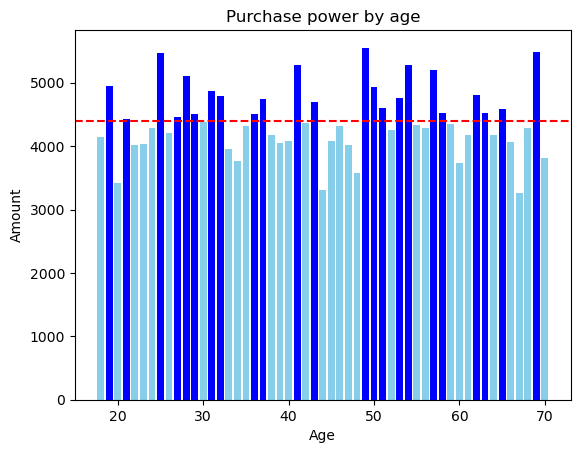

In [23]:
df_corr = df.copy()

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

plt.figure(figsize = (15,15))
columns_to_encode = [
    'Gender', 
    'Category', 
    'Location', 
    'Size', 
    'Color', 
    'Season', 
    'Subscription Status', 
    'Payment Method', 
    'Shipping Type', 
    'Discount Applied', 
    'Frequency of Purchases',
    'age_group'
]

# Encoding categorical columns
for column in columns_to_encode:
    if column in df_corr.columns:
        df_corr[column] = label_encoder.fit_transform(df_corr[column])
        
correlation = df_corr.corr().round(2)
sns.heatmap(correlation, annot = True, cmap = 'crest')
plt.show()


#gender distribution
gen_cnt = df['Gender'].value_counts()
gen_cnt.columns = ['gender','cnt']
plt.pie(gen_cnt, labels = gen_cnt.index,  autopct= '%1.2f%%')
plt.title('Gender distribution')
plt.show()


fig, axes = plt.subplots(2,2, figsize = (15,15))

size_order = ['S','M','L','XL']
df['Size']= pd.Categorical(df['Size'], categories = size_order, ordered = True)
sns.histplot(df['Size'], bins = 4, kde = True, ax = axes[0,0])
axes[0,0].set_title('Size  Distribution')

#sns.histplot(df['age_group'], bins = 8, kde = True, ax = axes[0,1])
sns.kdeplot(data=df[df['Gender'] == 'Female'], x='Age', fill=True, color = 'red', label ='Female', ax = axes[0,1])
sns.kdeplot(data=df[df['Gender'] == 'Male'], x='Age', fill=True, color = 'blue', label ='Male', ax = axes[0,1])
axes[0,1].set_title('Age Group Distribution')

sns.histplot(df['Age'], bins = 8, kde = True, ax = axes[1,0])
axes[1,0].set_title('Age  Distribution')

sns.histplot(df['Review Rating'], bins = 10, kde = True, ax = axes[1,1])
axes[1,1].set_title('Review Rating Distribution')



plt.show()

a = df.groupby('Age')['Purchase Amount (USD)'].sum().reset_index(name = 'Amount')
mean_amount = a['Amount'].mean()

colors = ['skyblue' if amount < mean_amount else 'blue' for amount in a['Amount']]


plt.bar(a['Age'], a['Amount'], color = colors)
plt.axhline(mean_amount, color = 'r', linestyle = '--')
plt.title('Purchase power by age')
plt.ylabel('Amount')
plt.xlabel('Age')
plt.show()





In [24]:
#gender purchase frequency distribution
gen_freq_dis = df.groupby('Gender')['Frequency of Purchases'].value_counts().reset_index(name = 'count')
female = gen_freq_dis[gen_freq_dis['Gender'] =='Female']
male = gen_freq_dis[gen_freq_dis['Gender'] =='Male']


gen_freq = female.merge(male, on = 'Frequency of Purchases', how ='left', suffixes=('_female', '_male'))

gen_freq


#subscription status
sub_acct = df[df['Subscription Status'] == 'Yes']

sub_acct = sub_acct[['Gender','Frequency of Purchases','Subscription Status']]

female_subscription = len(sub_acct[sub_acct['Gender'] == 'Female'])
male_subscription = len(sub_acct) - female_subscription
print(f'Frmale subscription: {female_subscription}\nMale subscription: {male_subscription}')

subscription_rate = len(sub_acct) / len(df)
print(f'Total subscription rate: {subscription_rate}') 


cnt = sub_acct.groupby(['Gender','Frequency of Purchases'])['Subscription Status'].count().reset_index(name = 'Male subcription status')

gen_freq = gen_freq.merge(cnt, on = 'Frequency of Purchases', how = 'left')

gen_freq['total_counts'] = gen_freq['count_female'] + gen_freq['count_male']
gen_freq['subscription_rate_male'] = (gen_freq['Male subcription status'] / gen_freq['count_male']).round(2)
gen_freq['subscription_rate_total'] = (gen_freq['Male subcription status'] / gen_freq['total_counts']).round(2)
gen_freq

cleaned_gen_freq = gen_freq[['Frequency of Purchases','count_female','count_male','Male subcription status','subscription_rate_male','total_counts','subscription_rate_total']]


gen_pur_power = df.groupby(['Gender','Frequency of Purchases'])['Purchase Amount (USD)'].sum().reset_index()
female = gen_pur_power[gen_pur_power['Gender'] =='Female']
male = gen_pur_power[gen_pur_power['Gender'] =='Male']

male.rename(columns = {'Purchase Amount (USD)': 'Purchase Amount (USD) Male'}, inplace = True)


gen_pur_power = male.merge(female[['Frequency of Purchases', 'Purchase Amount (USD)']], 
                  on='Frequency of Purchases', 
                  how='left', 
                  suffixes=('', ' Female'))

gen_pur_power.rename(columns={'Purchase Amount (USD)': 'Purchase Amount (USD) Female'}, inplace = True)
gen_pur_power.drop(columns = ['Gender'], inplace =True)

gender_summary = gen_pur_power.merge(cleaned_gen_freq, on = 'Frequency of Purchases', how = 'left')
gender_summary




Frmale subscription: 0
Male subscription: 1054
Total subscription rate: 0.27011788826242955


C:\Users\hosin\AppData\Local\Temp\ipykernel_13216\2627477568.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  male.rename(columns = {'Purchase Amount (USD)': 'Purchase Amount (USD) Male'}, inplace = True)


,Frequency of Purchases,Purchase Amount (USD) Male,Purchase Amount (USD) Female,count_female,count_male,Male subcription status,subscription_rate_male,total_counts,subscription_rate_total
0,Annually,23283,11136,185,387,160,0.41,572,0.28
1,Bi-Weekly,21936,11264,188,359,140,0.39,547,0.26
2,Every 3 Months,23526,11562,186,398,154,0.39,584,0.26
3,Fortnightly,22370,9637,163,379,153,0.40,542,0.28
4,Monthly,21722,11088,185,368,149,0.40,553,0.27
5,Quarterly,23403,10468,169,395,141,0.36,564,0.25
6,Weekly,21750,10036,172,367,157,0.43,539,0.29


In [25]:
#location analysis 
location = df.groupby('Location').agg({'Purchase Amount (USD)':'sum',                                       
                                       'Review Rating':'mean',
                                       'Previous Purchases': 'mean',}).reset_index().sort_values(by = 'Purchase Amount (USD)', ascending = False)
location

more_than_5000 = location.loc[location['Purchase Amount (USD)'] >= 5000, 'Location']
more_than_5000

filtered = df[df['Location'].isin(more_than_5000)][['Location', 'Gender', 'Category', 'Purchase Amount (USD)', 'Color', 'Season']]

location_seasons_sales = filtered.groupby(['Location','Season'])['Purchase Amount (USD)'].sum().reset_index()
location_genders_sales = filtered.groupby(['Location','Gender'])['Purchase Amount (USD)'].sum().reset_index()
location_categories_sales = filtered.groupby(['Location','Category'])['Purchase Amount (USD)'].sum().reset_index()
total_location_sales = filtered.groupby('Location')['Purchase Amount (USD)'].sum().reset_index()

location_seasons_sales['rnk'] = location_seasons_sales.groupby('Location')['Purchase Amount (USD)'].rank(method='dense', ascending=False)
location_genders_sales['rnk'] = location_genders_sales.groupby('Location')['Purchase Amount (USD)'].rank(method='dense', ascending=False)
location_categories_sales['rnk'] = location_categories_sales.groupby('Location')['Purchase Amount (USD)'].rank(method='dense', ascending=False)

season = location_seasons_sales.loc[location_seasons_sales['rnk'] ==1]
gender = location_genders_sales.loc[location_genders_sales['rnk'] ==1]
category = location_categories_sales.loc[location_categories_sales['rnk'] ==1]



season.rename(columns = {'Purchase Amount (USD)': 'Season Purchase Amount (USD)'}, inplace = True)
gender.rename(columns = {'Purchase Amount (USD)': 'Gender Purchase Amount (USD)'}, inplace = True)
category.rename(columns = {'Purchase Amount (USD)': 'Category Purchase Amount (USD)'}, inplace = True)

top_performance_in_each_location = season.merge(gender[['Gender','Location','Gender Purchase Amount (USD)']], on = 'Location', how = 'left')
top_performance_in_each_location.drop(columns=['rnk'], inplace=True)

top_performance_in_each_location = top_performance_in_each_location.merge(category[['Category','Location','Category Purchase Amount (USD)']], on = 'Location', how = 'left')
top_performance_in_each_location = top_performance_in_each_location.merge(total_location_sales, on = 'Location',how = 'left')

top_performance_in_each_location.rename(columns={'Purchase Amount (USD)': 'Total Purchase Amount (USD) '}, inplace = True)
top_performance_in_each_location

C:\Users\hosin\AppData\Local\Temp\ipykernel_13216\1467567747.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season.rename(columns = {'Purchase Amount (USD)': 'Season Purchase Amount (USD)'}, inplace = True)
C:\Users\hosin\AppData\Local\Temp\ipykernel_13216\1467567747.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gender.rename(columns = {'Purchase Amount (USD)': 'Gender Purchase Amount (USD)'}, inplace = True)
C:\Users\hosin\AppData\Local\Temp\ipykernel_13216\1467567747.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

,Location,Season,Season Purchase Amount (USD),Gender,Gender Purchase Amount (USD),Category,Category Purchase Amount (USD),Total Purchase Amount (USD)
0,Alabama,Summer,1610,Male,3583,Clothing,2334,5261
1,California,Fall,1659,Male,3869,Clothing,2740,5605
2,Idaho,Fall,1622,Male,3715,Clothing,2472,5587
3,Illinois,Spring,1620,Male,3698,Clothing,2508,5617
4,Montana,Winter,1631,Male,3600,Clothing,2768,5784
5,Nebraska,Fall,1389,Male,3377,Accessories,2147,5172
6,Nevada,Spring,1916,Male,3642,Clothing,2515,5514
7,New Mexico,Fall,1360,Male,3668,Clothing,1925,5014
8,New York,Fall,1576,Male,3674,Clothing,2254,5257
9,North Dakota,Summer,1656,Male,3671,Clothing,2206,5220


### 4. **Review Rating Analysis**
   - **Analysis**: Analyze how review ratings correlate with purchase amounts and customer demographics. 
   - **Objective**: Understand what factors contribute to higher ratings and how they influence sales.

C:\Users\hosin\AppData\Local\Temp\ipykernel_13216\1823653686.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rr_analysis['Location'] = label_encoder.fit_transform(rr_analysis['Location'])
C:\Users\hosin\AppData\Local\Temp\ipykernel_13216\1823653686.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rr_analysis['Category'] = label_encoder.fit_transform(rr_analysis['Category'])
C:\Users\hosin\AppData\Local\Temp\ipykernel_13216\1823653686.py:6: SettingWithCopyWarning: 
A value is trying to be set on a cop

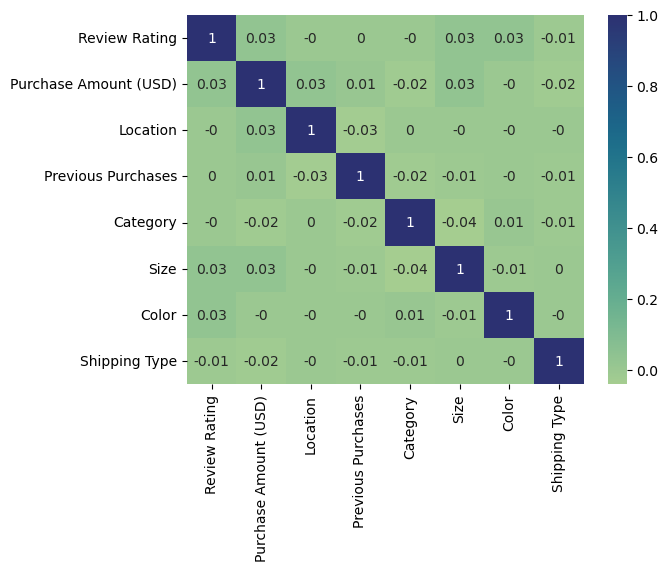

The correlations are weak, showing that customer reviews are basically rely on personal perception of that purchase.
purchas amount, size and color show the largest correlation of 0.03 to review rating, even the correlation is low, but it is valuable to note that these factors could still provide insights into customer behavior. For example, customers might rate a product higher if they perceive it as a good deal (purchase amount) or if the size and color meet their expectations.


In [27]:
rr_analysis = df[['Review Rating','Purchase Amount (USD)','Location','Previous Purchases','Category','Size','Color','Shipping Type']]

label_encoder = LabelEncoder()
rr_analysis['Location'] = label_encoder.fit_transform(rr_analysis['Location'])
rr_analysis['Category'] = label_encoder.fit_transform(rr_analysis['Category'])
rr_analysis['Size'] = label_encoder.fit_transform(rr_analysis['Size'])
rr_analysis['Color'] = label_encoder.fit_transform(rr_analysis['Color'])
rr_analysis['Shipping Type'] = label_encoder.fit_transform(rr_analysis['Shipping Type'])

corr = rr_analysis.corr().round(2)

sns.heatmap(corr, annot = True, cmap = 'crest')
plt.show()

print('The correlations are weak, showing that customer reviews are basically rely on personal perception of that purchase.')
print('purchas amount, size and color show the largest correlation of 0.03 to review rating, even the correlation is low, but it is valuable to note that these factors could still provide insights into customer behavior. For example, customers might rate a product higher if they perceive it as a good deal (purchase amount) or if the size and color meet their expectations.')


### 5. **Subscription and Retention Analysis**
   - **Analysis**: Explore the impact of subscription status on purchase frequency and amount. Compare subscribers vs. non-subscribers.
   - **Objective**: Identify the benefits of subscription models and improve retention strategies.

In [29]:
df.head()
frequency_mapping = {
    'Fortnightly': 26,
    'Bi-Weekly': 26,
    'Weekly': 52,
    'Monthly': 12,
    'Quarterly': 4,
    'Every 3 Months': 4,
    'Annually': 1
}
 

df['Expected yearly purchase frequency'] = df['Frequency of Purchases'].replace(frequency_mapping)
df

C:\Users\hosin\AppData\Local\Temp\ipykernel_13216\369915847.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Expected yearly purchase frequency'] = df['Frequency of Purchases'].replace(frequency_mapping)


,Age,Gender,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Payment Method,Shipping Type,Discount Applied,Previous Purchases,Frequency of Purchases,age_group,cluster,Expected yearly purchase frequency
0,55,Male,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Credit Card,Express,Yes,14,Fortnightly,51-60,2,26
1,19,Male,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Bank Transfer,Express,Yes,2,Fortnightly,0-20,1,26
2,50,Male,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Cash,Free Shipping,Yes,23,Weekly,41-50,1,52
3,21,Male,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,PayPal,Next Day Air,Yes,49,Weekly,21-30,0,52
4,45,Male,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Cash,Free Shipping,Yes,31,Annually,41-50,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3897,46,Female,Accessories,33,New Jersey,L,Green,Spring,2.9,No,Credit Card,Standard,No,24,Quarterly,41-50,2,4
3898,44,Female,Footwear,77,Minnesota,S,Brown,Summer,3.8,No,PayPal,Express,No,24,Weekly,41-50,1,52
3899,52,Female,Accessories,81,California,M,Beige,Spring,3.1,No,Bank Transfer,Store Pickup,No,33,Quarterly,51-60,0,4
3900,25,Male,Clothing,100,Oregon,L,White,Winter,4.0,Yes,PayPal,Free Shipping,Yes,5,Quarterly,21-30,1,4


In [30]:
sub = df[df['Subscription Status'] == 'Yes'][['Purchase Amount (USD)','Subscription Status','Expected yearly purchase frequency','Previous Purchases']]
sub['relationship_with_company(yr)'] = (sub['Previous Purchases'] +1) / sub['Expected yearly purchase frequency']

non_sub = df[df['Subscription Status'] == 'No'][['Purchase Amount (USD)','Subscription Status','Expected yearly purchase frequency','Previous Purchases']]
non_sub['relationship_with_company(yr)'] = (non_sub['Previous Purchases'] +1) / non_sub['Expected yearly purchase frequency']

sub_matric = {
    'Total purchase size': sub['Purchase Amount (USD)'].sum(),
    'Average purchase size': sub['Purchase Amount (USD)'].mean(),
    'Average past purchase count': sub['Expected yearly purchase frequency'].mean(),
    'Average customer relatuionship with the company': sub['relationship_with_company(yr)'].mean()
}
non_sub_matric = {
    'Total purchase size': non_sub['Purchase Amount (USD)'].sum(),
    'Average purchase size': non_sub['Purchase Amount (USD)'].mean(),
    'Average past purchase count': non_sub['Expected yearly purchase frequency'].mean(),
    'Average customer relatuionship with the company': non_sub['relationship_with_company(yr)'].mean()
}

sra_df = pd.DataFrame({'Subscribers':sub_matric,
                       'Non-Subscribers':non_sub_matric})
print(sra_df)

result = 'Non Subscribers contribute 2.8x more than Subscribers in total purchase size\nBoth subscribers and non-subscribers share similar avergae purchase size, average past purchase count and relationship with the company\n'
solution = 'Enhance subscription values: create add value and benefits to attract no sub-subscribers to convert to subscribers.\n Enahnce loyalty programmes to incentivise subscriber with high purchase frequency '
print(result, solution)


                                                  Subscribers  Non-Subscribers
Total purchase size                              62745.000000    170486.000000
Average purchase size                               59.530361        59.861657
Average past purchase count                         17.941176        17.287921
Average customer relatuionship with the company      6.477278         6.350559
Non Subscribers contribute 2.8x more than Subscribers in total purchase size
Both subscribers and non-subscribers share similar avergae purchase size, average past purchase count and relationship with the company
 Enhance subscription values: create add value and benefits to attract no sub-subscribers to convert to subscribers.
 Enahnce loyalty programmes to incentivise subscriber with high purchase frequency 
